# Project 2: Regression Challenge (HDB Prices)

## 03: Pre-Processing and Modelling

### Import Libraries

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [2]:
# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Data

In [3]:
# Import the cleaned train data
hdb = pd.read_csv('../datasets/train_cleaned.csv')

In [4]:
# Import the uncleaned test data so that we can clean and process it later
hdb_test = pd.read_csv('../datasets/test.csv')

/var/folders/cy/2hh9tprx00z5ld32c942nw240000gn/T/ipykernel_72961/209345050.py:2: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_test = pd.read_csv('../datasets/test.csv')


In [5]:
# Take a quick look at the data
hdb.head()

,town,flat_type,floor_area_sqm,flat_model,resale_price,tranc_year,tranc_month,mid,commercial,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,mall_nearest_distance,hawker_nearest_distance,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,lease_remaining_years
0,KALLANG/WHAMPOA,4 ROOM,90.0,Model A,680000.0,2016,5,11,N,142,0,0,0,96,46,0,0,0,1094.090418,154.753357,1,330.083069,0,0,29.427395,1138.633422,1138.633422,84
1,BISHAN,5 ROOM,130.0,Improved,665000.0,2012,7,8,N,112,0,0,0,56,56,0,0,0,866.941448,640.151925,1,903.659703,1,1,58.207761,415.607357,447.894399,65
2,BUKIT BATOK,EXECUTIVE,144.0,Apartment,838000.0,2013,7,14,N,90,0,0,0,0,30,60,0,0,1459.579948,1762.082341,1,1334.251197,1,0,214.747860,498.849039,180.074558,75
3,BISHAN,4 ROOM,103.0,Model A,550000.0,2012,4,3,Y,75,0,0,0,68,7,0,0,0,950.175199,726.215262,1,907.453484,1,1,43.396521,389.515528,389.515528,70
4,YISHUN,4 ROOM,83.0,Simplified,298000.0,2017,12,2,N,48,0,0,0,30,18,0,0,0,729.771895,1540.151439,0,412.343032,0,0,129.422752,401.200584,312.025435,65


### One Hot Encoding for Categorical Features

To enable the use of the catagorical features in the regression model, we will perform one-hot encoding to split them into multiple columns. 

In [6]:
# Check the number of columns in the dataset before one-hot encoding 
hdb.shape[1]

28

In [7]:
# Perform one-hot encoding to convert categorical features into dummy variables
hdb = pd.get_dummies(hdb, columns=['town', 'flat_type', 
                                   'tranc_year', 'tranc_month'], drop_first=True)

# We will one-hot encode flat_type seperately from the rest as the test dataset 
# does not have the flat_model "2-room". hence, we will drop it manually for the train set
hdb = pd.get_dummies(hdb, columns=['flat_model'])
hdb.drop(columns='flat_model_2-room', inplace=True)

In [8]:
# Check that the one-hot encoding was successful
hdb.columns

Index(['floor_area_sqm', 'resale_price', 'mid', 'commercial',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', 'mall_nearest_distance',
       'hawker_nearest_distance', 'hawker_market_stalls',
       'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance',
       'sec_sch_nearest_dist', 'lease_remaining_years', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS',

In [9]:
# Check the number of columns in the dataset after one-hot encoding 
hdb.shape[1]

93

### Convert Y/N features into 1/0

We'll use list comprehension to convert the commercial columns from Y/N to 1/0

In [10]:
# Convert Y/N into 1/0
hdb['commercial'] = [1 if x == 'Y' else 0 for x in hdb['commercial']]

In [11]:
# Check if the conversion was successful
hdb['commercial'].value_counts()

0    121815
1     28819
Name: commercial, dtype: int64

### Train/Test Split

In this section, we will split our train data into train and validation (val) sets

In [12]:
# Define X and y variables
X = hdb.drop(columns='resale_price')
y = hdb['resale_price']

In [13]:
# Perform train test split to get our 
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.2, 
                                                  random_state=42)

### Scaling

Since our features have a range of values from 0/1 to distances above 3000m, we will need to scale our data. Furthermore, scaling would also be important as we will be considering the use of regularization

In [14]:
# Instantiate the standard scaler
ss = StandardScaler()

In [15]:
# Fit and transform the X and y variables
X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

### Baseline Score

We will calculate the baseline score first. This is done by creating a dummy model to act as a baseline mode. All models trained later on can compare against this score to base its performance.

In [16]:
# Instantiate dummy regressor using mean
dummy_regr = DummyRegressor(strategy='mean')

In [17]:
# Fit the dummy regressor
dummy_regr.fit(X_train_ss, y_train)

DummyRegressor()

In [18]:
# Check the score of the baseline model with train data
dummy_regr.score(X_train_ss, y_train)

0.0

In [19]:
# Check the score of the baseline model with validation data
dummy_regr.score(X_val_ss, y_val)

-1.74203458778166e-05

In [20]:
# Perform prediction using the baseline model with the validation data
pred_dummy = dummy_regr.predict(X_val_ss)

In [21]:
# Check the score of the baseline model with validation data
r2_score(y_val, pred_dummy)

-1.74203458778166e-05

In [22]:
# Check the RSME value of the baseline model
mean_squared_error(y_val, pred_dummy, squared=False)

143378.08782784882

### Linear Regression Model

We will kick off with a basic linear regression model.

In [23]:
# Instantiate the model
lr = LinearRegression()

# Fit the model
lr.fit(X_train_ss, y_train)

# Generate predictions using the validation data
pred_lr = lr.predict(X_val_ss)

In [24]:
# Evaluate the linear regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y_train, lr.predict(X_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y_val, pred_lr, squared=False)}')

RMSE on training set: 47556.41078150995
RMSE on validation set: 413278422637917.25


In [25]:
# Evaluate the linear regression model using R2 score
print(f'R^2 on training set: {r2_score(y_train, lr.predict(X_train_ss))}')
print(f'R^2 on validation set: {r2_score(y_val, pred_lr)}')

R^2 on training set: 0.8894437208029856
R^2 on validation set: -8.308592511088723e+18


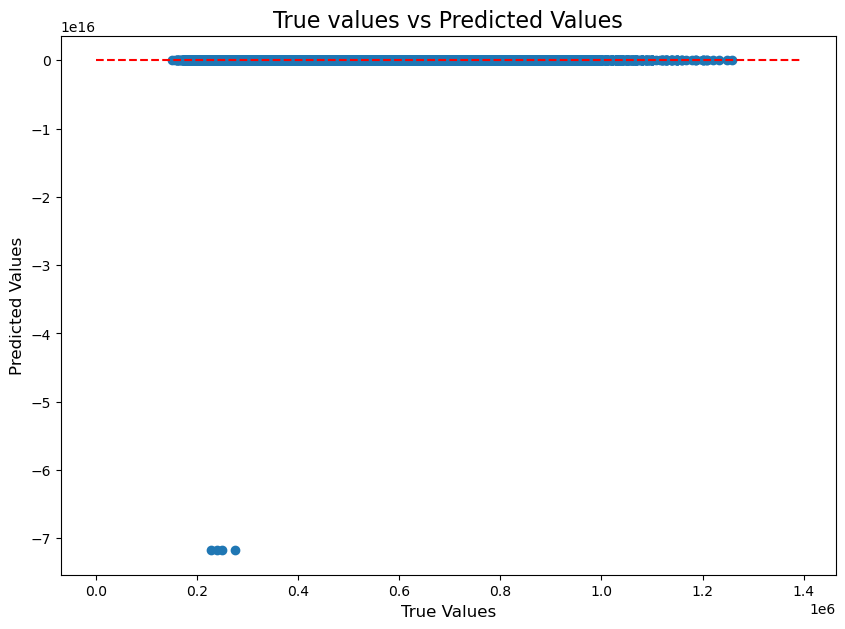

In [26]:
# Plot the true y values against the predicted values
plt.figure(figsize = (10,7))

# Examine the relationship between observed and predicted values.
plt.scatter(y_val, pred_lr)

# Line showing perfect predictions.
plt.plot([0, max(max(y_val),max(pred_lr))],
         [0, max(max(y_val),max(pred_lr))],
         linestyle = '--', color='red')

plt.title('True values vs Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12);

Based on the RMSE, our model is performing far worse on the validation set than the training set, meaning our model as likely overfit to the data. Furthermore, the model's performance is worse than the base model. An explanation for this could be due to the model overfitting as there might be some irrelevant input features. This theory is supported by the fact that when coefficients are penalized by regulation, this issue was not occur.  
Based on the $R^2$, our model does not explain the variance of the $Y$ data.  
Hence, we can conclude this is a bad model.  

### Ridge Regression

Now let's try performing regularization to see if we can reduce overfitting and get a better performing model. We will start with Ridge Regression first. 

In [27]:
# Set up a list of ridge alpha values to check
r_alphas = np.logspace(0,5,100)

# Cross-validate over our list of ridge alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_root_mean_squared_error', 
                   cv=5)

# Fit the Ridge Cross Validation model
ridge_cv.fit(X_train_ss, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='neg_root_mean_squared_error')

In [28]:
# Check the optimal value of alpha for the ridge model
ridge_cv.alpha_

5.722367659350217

In [29]:
# Instantiate the ridge model with the optimal alpha value
ridge_model = Ridge(alpha=ridge_cv.alpha_)

# Fit the model
ridge_model.fit(X_train_ss, y_train)

# Generate predictions using the validation data
pred_ridge = ridge_model.predict(X_val_ss)

In [30]:
# Evaluate the ridge regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y_train, ridge_model.predict(X_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y_val, pred_ridge, squared=False)}')

RMSE on training set: 47556.348708533
RMSE on validation set: 47854.578463338126


In [31]:
# Evaluate the ridge regression model using R2 score
print(f'R^2 on training set: {r2_score(y_train, ridge_model.predict(X_train_ss))}')
print(f'R^2 on validation set: {r2_score(y_val, pred_ridge)}')

R^2 on training set: 0.8894440094098329
R^2 on validation set: 0.8885990261624512


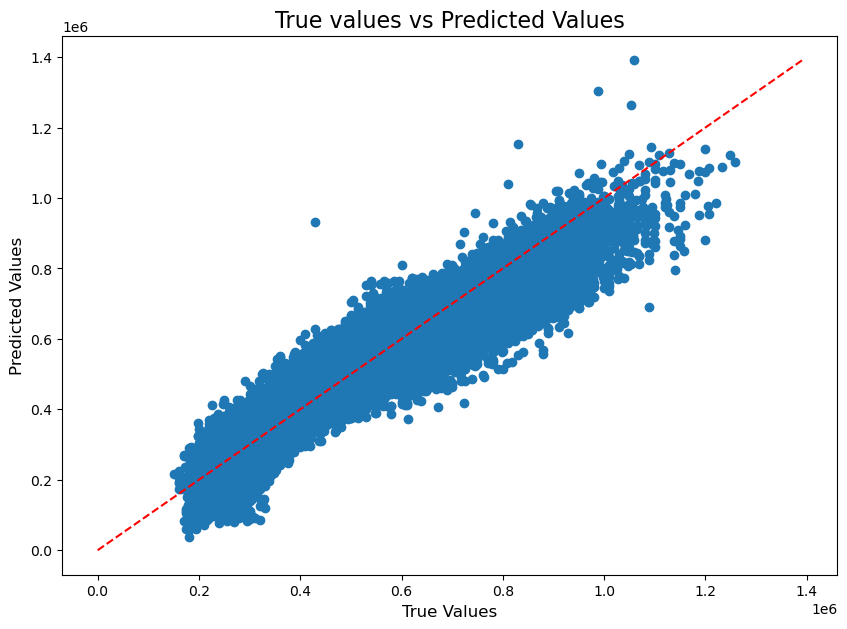

In [32]:
# Plot the true y values against the predicted values
plt.figure(figsize = (10,7))

# Examine the relationship between observed and predicted values.
plt.scatter(y_val, pred_ridge)

# Line showing perfect predictions.
plt.plot([0, max(max(y_val),max(pred_ridge))],
         [0, max(max(y_val),max(pred_ridge))],
         linestyle = '--', color='red')

plt.title('True values vs Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12);

Based on the RMSE, our model is performing as well on the validation set as the training set, meaning our model has not overfit on the data and is performing well.   
Based on the $R^2$, our model explains the variance of the $Y$ data quite well.  
We also note that the mdoel with ridge regression has significantly outperformed the base model.  
Hence, we can conclude that this is a pretty good model.  

### Lasso Regression

Let's try Lasso Regression next. 

In [33]:
# Set up a list of lasso alpha values to check
l_alphas = np.logspace(-3,1,100)

# Cross-validate over our list of lasso alphas
lasso_cv = LassoCV(alphas=r_alphas, cv=5)

# Fit the Lasso Cross Validation model
lasso_cv.fit(X_train_ss, y_train)

LassoCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [34]:
# Check the optimal value of alpha for the lasso model
lasso_cv.alpha_

29.150530628251758

In [35]:
# Instantiate the lasso model with the optimal alpha value
lasso_model = Lasso(alpha=lasso_cv.alpha_)

# Fit the model
lasso_model.fit(X_train_ss, y_train)

# Generate predictions using the validation data
pred_lasso = lasso_model.predict(X_val_ss)

In [36]:
# Evaluate the lasso regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y_train, lasso_model.predict(X_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y_val, pred_lasso, squared=False)}')

RMSE on training set: 47558.9198279408
RMSE on validation set: 47859.18871081305


In [37]:
# Evaluate the lasso regression model using R2 score
print(f'R^2 on training set: {r2_score(y_train, lasso_model.predict(X_train_ss))}')
print(f'R^2 on validation set: {r2_score(y_val, pred_lasso)}')

R^2 on training set: 0.8894320547352293
R^2 on validation set: 0.888577560680404


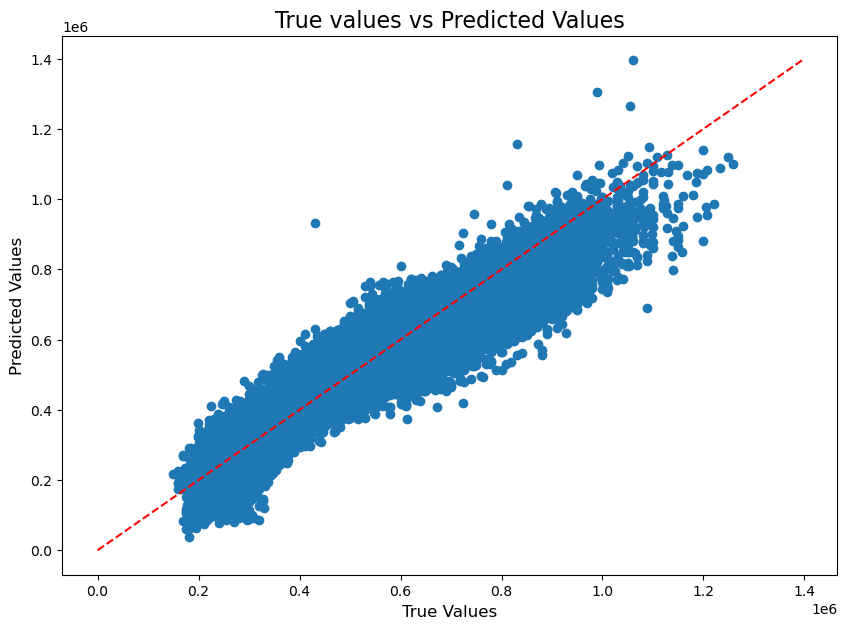

In [38]:
# Plot the true y values against the predicted values
plt.figure(figsize = (10,7))

# Examine the relationship between observed and predicted values.
plt.scatter(y_val, pred_lasso)

# Line showing perfect predictions.
plt.plot([0, max(max(y_val),max(pred_lasso))],
         [0, max(max(y_val),max(pred_lasso))],
         linestyle = '--', color='red')

plt.title('True values vs Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12);

Based on the RMSE, our model is performing as well on the validation set as the training set, meaning our model has not overfit on the data and is performing well.   
Based on the $R^2$, our model explains the variance of the $Y$ data quite well.  
We also note that the mdoel with lasso regression has significantly outperformed the base model.  
Hence, we can conclude that this is a pretty good model.  

### Elastic Net Regression

Let's try Elastic Net Regression next. 

In [39]:
# Set up a list of lasso alpha values to check
enet_alphas = np.linspace(0.5,2.0,100)

# Set up our l1 ratio. (What does this do?)
enet_ratio = 0.5

# Cross-validate over our list of lasso alphas
enet_cv = ElasticNetCV(alphas=r_alphas, l1_ratio=enet_ratio, cv=5)

# Fit the Elastic Net Cross Validation model
enet_cv.fit(X_train_ss, y_train)

ElasticNetCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.149757...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
             cv=5)

In [40]:
# Check the optimal value of alpha for the Elastic Net model
enet_cv.alpha_

1.0

In [41]:
# Instantiate the Elastic Net model with the optimal alpha value
enet_model = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=0.5)

# Fit the model
enet_model.fit(X_train_ss, y_train)

# Generate predictions using the validation data
pred_enet = enet_model.predict(X_val_ss)

In [42]:
# Evaluate the Elastic Net regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y_train, enet_model.predict(X_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y_val, pred_enet, squared=False)}')

RMSE on training set: 61640.50263556134
RMSE on validation set: 62286.22440567386


In [43]:
# Evaluate the Elastic Net regression model using R2 score
print(f'R^2 on training set: {r2_score(y_train, enet_model.predict(X_train_ss))}')
print(f'R^2 on validation set: {r2_score(y_val, pred_enet)}')

R^2 on training set: 0.814263346090272
R^2 on validation set: 0.8112764881311858


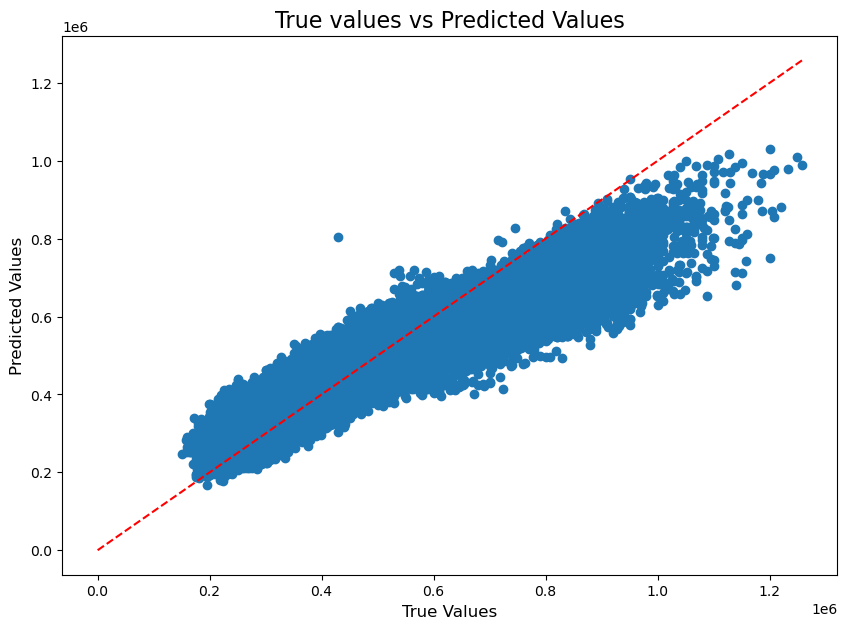

In [44]:
# Plot the true y values against the predicted values
plt.figure(figsize = (10,7))

# Examine the relationship between observed and predicted values.
plt.scatter(y_val, pred_enet)

# Line showing perfect predictions.
plt.plot([0, max(max(y_val),max(pred_enet))],
         [0, max(max(y_val),max(pred_enet))],
         linestyle = '--', color='red')

plt.title('True values vs Predicted Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12);

Based on the RMSE, our model is performing as well on the validation set as the training set, meaning our model has not overfit on the data and is performing well.   
Based on the $R^2$, our model explains the variance of the $Y$ data quite well.  
We also note that the mdoel with elastic net regression has significantly outperformed the base model.  
Hence, we can conclude that this is a pretty good model.  

### Feature Selection

Now that we have created multiple models, let's take another look at the features and coefficients to remove noise and any multi-collinearity that was introduced from one-hot encoding.

Firstly, we'll take a look at the coefficients of the best two performing models (Ridge and Lasso) to identify and remove noisy features.

#### Ridge Model Coefficients

In [45]:
# Create a list of the coefficients for the Ridge model
# Tag the feature names to the respective coefficients
ridge_coeffs = pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : ridge_model.coef_,
    'Absolute Coefficient' : np.abs(ridge_model.coef_)
})
# Sort the values by descending order
ridge_coeffs.sort_values('Coefficient', ascending=False);

In [46]:
# Sort the Ridge model coefficients in descending order
ridge_coeffs_sorted = ridge_coeffs.sort_values('Coefficient', ascending=False)

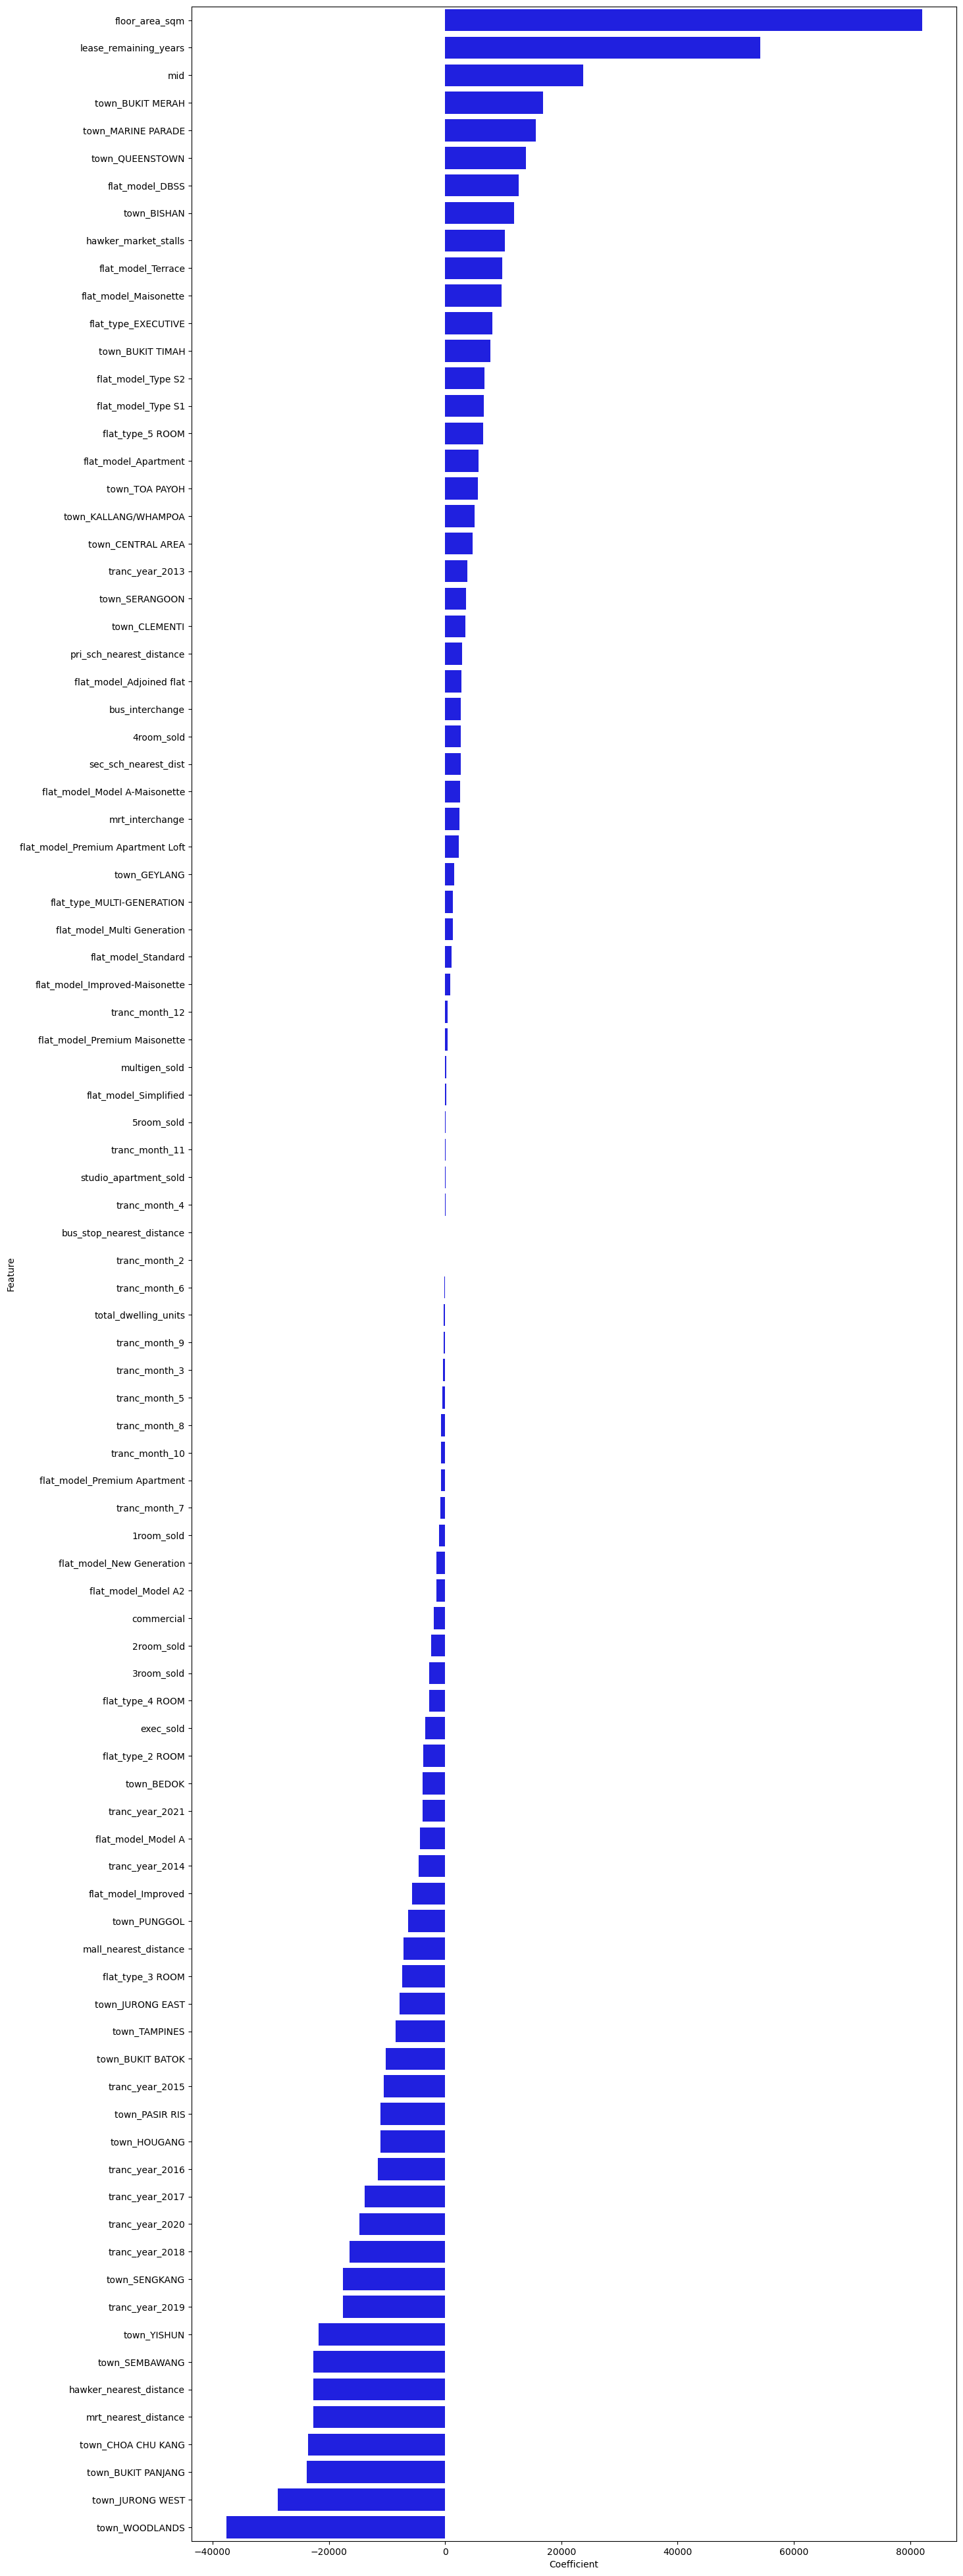

In [47]:
# Plot the Ridge model coefficients in descending order
fix, ax = plt.subplots(figsize=(15,50))
sns.barplot(data=ridge_coeffs_sorted, x='Coefficient', y='Feature', orient='h', color='blue');

#### Lasso Model Coefficients

In [48]:
# Create a list of the coefficients for the Lasso model
# Tag the feature names to the respective coefficients
lasso_coeffs = pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : lasso_model.coef_,
    'Absolute Coefficient' : np.abs(lasso_model.coef_)
})
# Sort the values by descending order
lasso_coeffs.sort_values('Coefficient', ascending=False);

In [49]:
# Sort the Lasso model coefficients in descending order
lasso_coeffs_sorted = lasso_coeffs.sort_values('Coefficient', ascending=False)

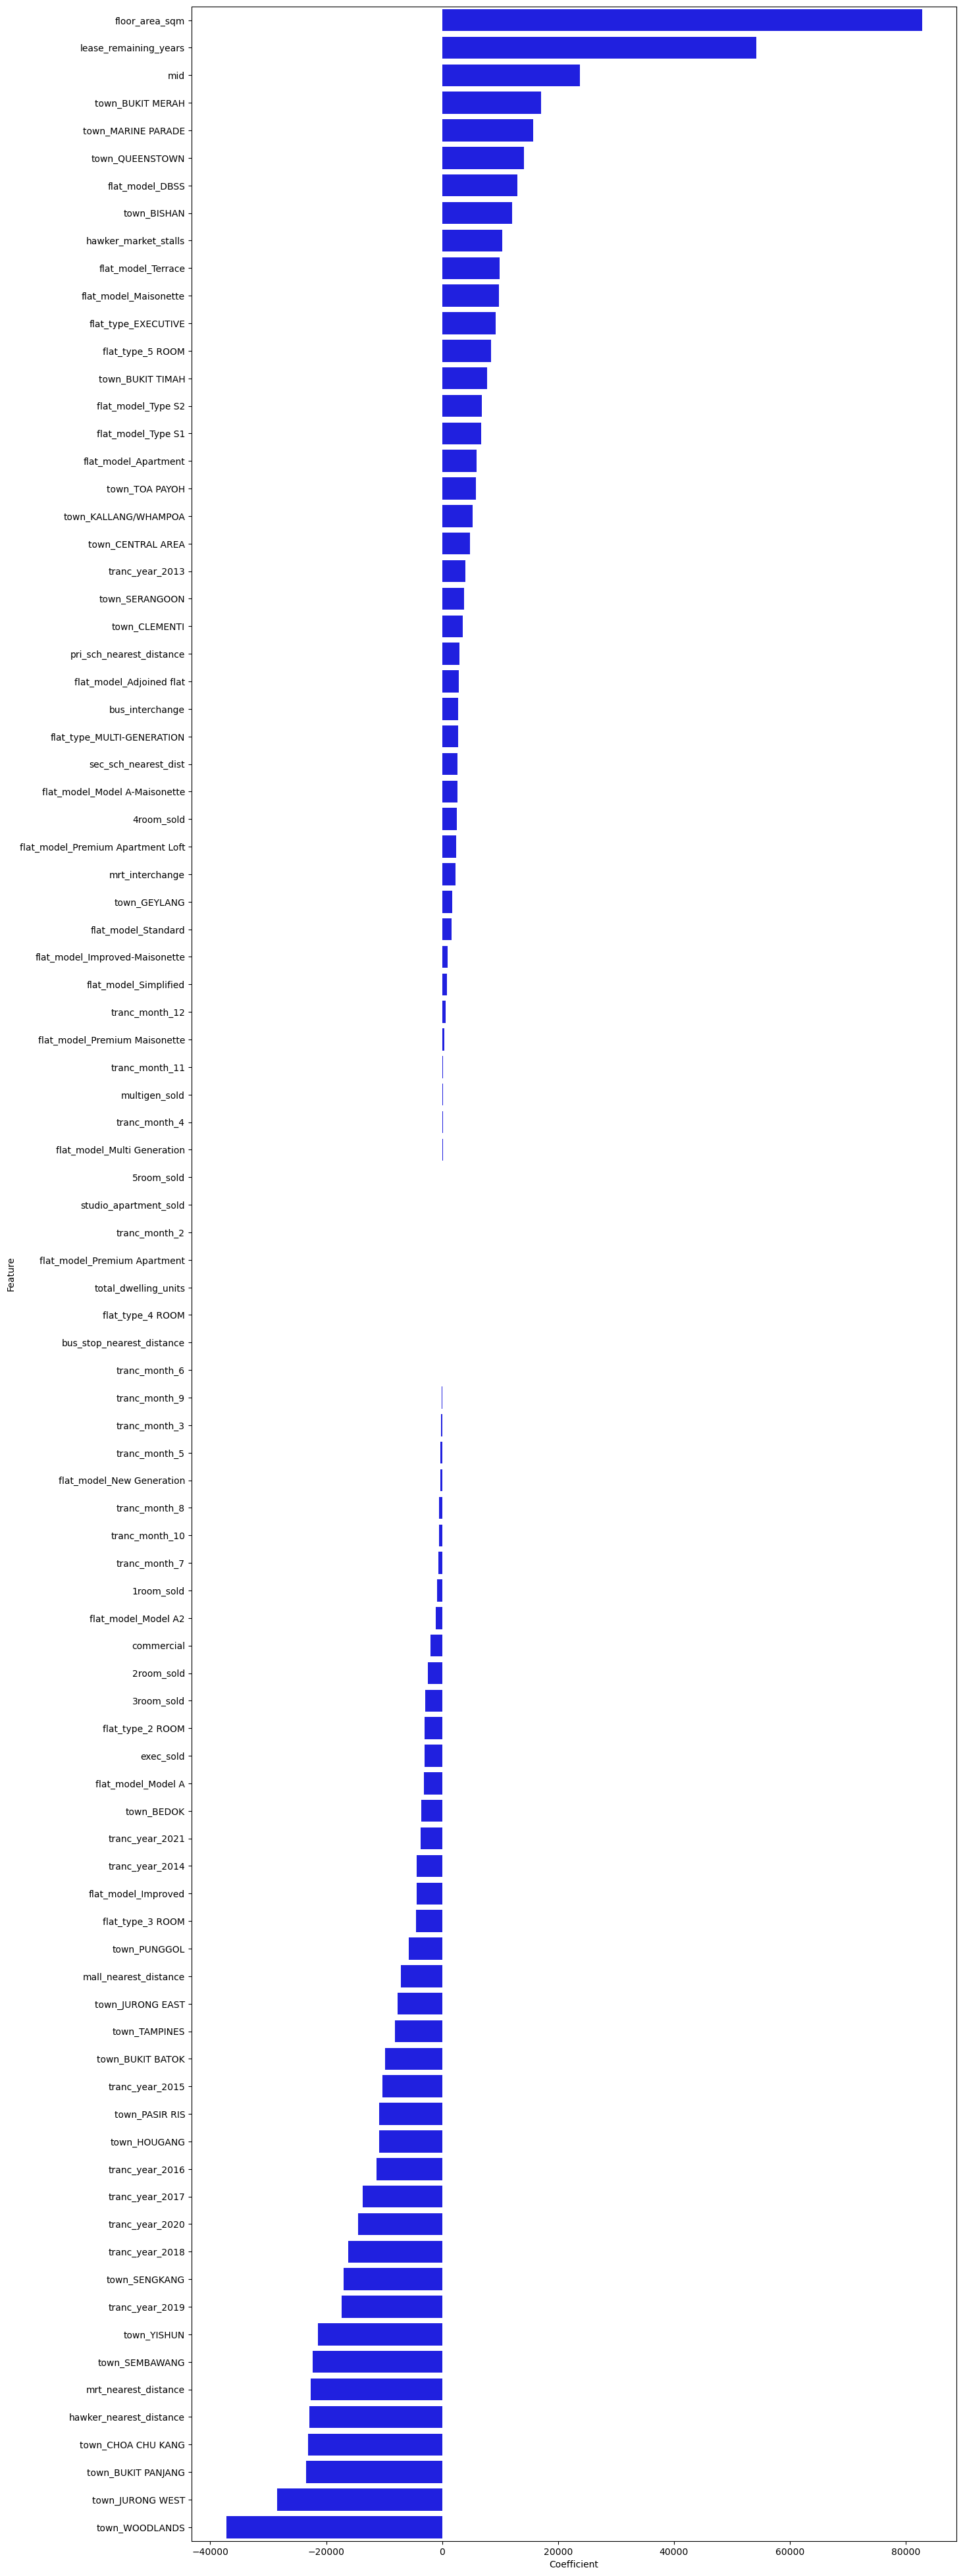

In [50]:
# Plot the Lasso model coefficients in descending order
fix, ax = plt.subplots(figsize=(15,50))
sns.barplot(data=lasso_coeffs_sorted, x='Coefficient', y='Feature', orient='h', color='blue');

#### Noisy Features to Drop

Looking at the coefficients of both the Lasso and Ridge model, we can drop the following features:

| Columns to drop | Rationale |
|-----------------|-----------|
|transaction months |Most of the transaction months were heavily penalized and has little effect to the model|
|bus stop nearest distance| This coefficient was penalized to zero|
|number of rooms sold| These coefficients were heaviliy penalized. This could be because buyers might rather look at the floor area instead|
|flat models| Most of the flat models were heavily penalized|
|total dwelling units| This coefficient was penalized to zero|
|hawker_food_stalls| This coefficient was penalized to zero|
|flat types| Most of the flat types were heavily penalized|
|commericial| This coefficient was heavily penalized|
|bus interchange| This coefficient was heavily penalized|
|mrt interchange| This coefficient was heavily penalized|
|primary and secondary school nearest distance| This coefficient was heavily penalized| 

In [51]:
hdb.columns

Index(['floor_area_sqm', 'resale_price', 'mid', 'commercial',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', 'mall_nearest_distance',
       'hawker_nearest_distance', 'hawker_market_stalls',
       'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance',
       'sec_sch_nearest_dist', 'lease_remaining_years', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS',

In [52]:
# Drop the columns identified above
hdb2 = hdb.drop(columns=['commercial', 'total_dwelling_units', '1room_sold', 
                         '2room_sold', '3room_sold', '4room_sold', '5room_sold',
                         'exec_sold', 'multigen_sold', 'studio_apartment_sold',
                         'bus_interchange', 
                         'mrt_interchange', 'bus_stop_nearest_distance', 
                         'pri_sch_nearest_distance', 'sec_sch_nearest_dist',
                         'flat_type_2 ROOM', 'flat_type_3 ROOM', 
                         'flat_type_4 ROOM', 'flat_type_5 ROOM', 
                         'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION',
                         'tranc_month_2', 'tranc_month_3', 'tranc_month_4', 
                         'tranc_month_5', 'tranc_month_6', 'tranc_month_7', 
                         'tranc_month_8', 'tranc_month_9', 'tranc_month_10', 
                         'tranc_month_11', 'tranc_month_12', 
                         'flat_model_Adjoined flat', 'flat_model_Apartment', 
                         'flat_model_DBSS', 'flat_model_Improved', 
                         'flat_model_Improved-Maisonette','flat_model_Maisonette', 
                         'flat_model_Model A', 'flat_model_Model A-Maisonette',
                         'flat_model_Model A2', 'flat_model_Multi Generation', 
                         'flat_model_New Generation', 'flat_model_Premium Apartment', 
                         'flat_model_Premium Apartment Loft', 
                         'flat_model_Premium Maisonette', 'flat_model_Simplified',
                         'flat_model_Standard', 'flat_model_Terrace', 
                         'flat_model_Type S1', 'flat_model_Type S2'])

We'll look at the correlation heatmap next to to check for multi-collinearity.

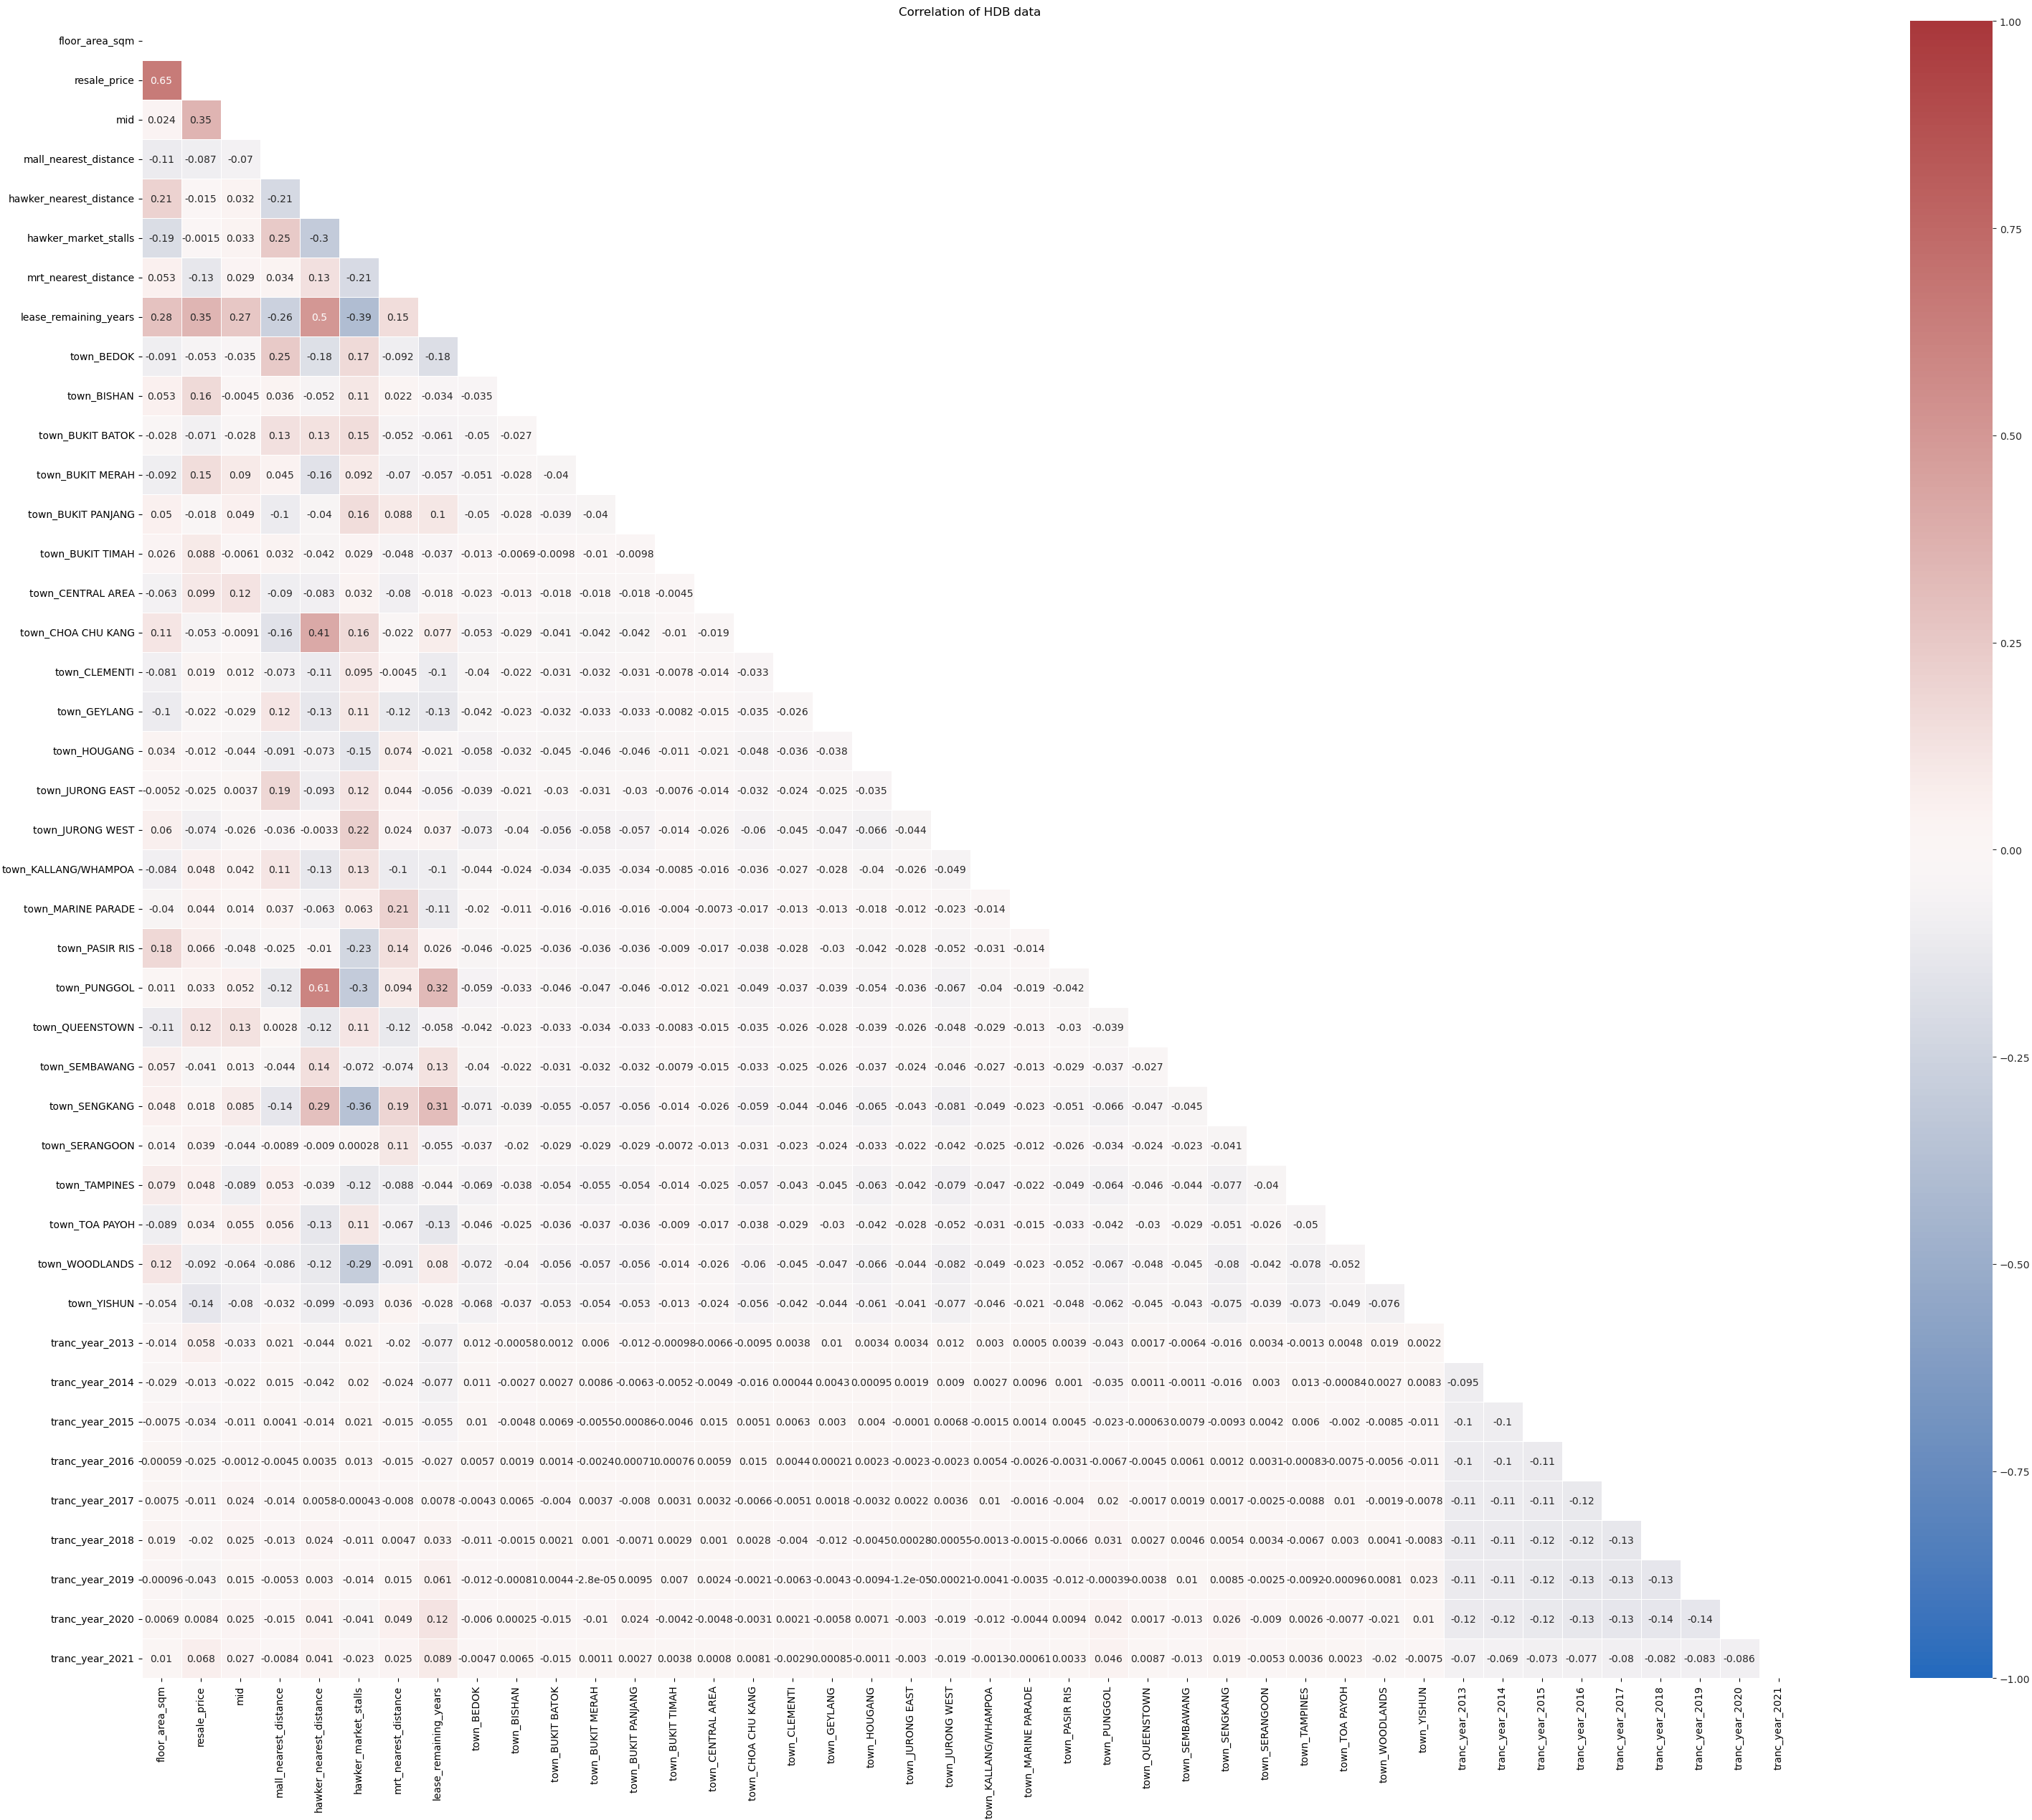

In [53]:
# Establish size of figure.
plt.figure(figsize = (40,30))

# Title
plt.title("Correlation of HDB data")

# Drop the categorical varialbes and get the correlation of the numerical variables.
corr_hdb2 = hdb2.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr_hdb2)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr_hdb2, mask = mask, square = True, annot = True, vmin = -1, 
                vmax = 1, linewidths = .5, cmap='vlag')

There are only three features with high correlation (corr > 0.5):

|Col 1| Col 2| Corr | Analysis|
|-----|-----|------|---------|
|resale_price| floor_area_sqm|0.65| This is between our X and y variables. Good to keep as we know it will help with the accuracy of the model|
|lease_remaining_years| hawker_nearest_distance| 0.5| No link between these two variables. To keep both|
|town_PUNGGOL| hawker_nearest_distance| 0.61| Not much link in terms of multi-colliinearity here. It could be that Punggol is a dense town, and most flats are close to hawker centres|

#### Updated Dataset

Below is the updated dataset following our feature selection by reviewing noisy features and multi-collinearity

In [54]:
# Check what are the columns remaining in the data set
hdb2.columns

Index(['floor_area_sqm', 'resale_price', 'mid', 'mall_nearest_distance',
       'hawker_nearest_distance', 'hawker_market_stalls',
       'mrt_nearest_distance', 'lease_remaining_years', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'tranc_year_2013', 'tranc_year_2014', 'tranc_year_2015',
       'tranc_year_2016', 'tranc_year_2017', 'tranc_year_2018',
       'tranc_year_2019', 'tranc_year_2020', 'tranc_year_2021'],
      dtype='object')

In [55]:
# Check the shape of the new data set
hdb2.shape

(150634, 42)

## Training New Models with the New Dataset

In this section, we'll split and scale the new dataset, and proceed to train a new set of models. The steps are similar as done above

### Train/Test Split

In [56]:
# Define X and y variables
X2 = hdb2.drop(columns='resale_price')
y2 = hdb2['resale_price']

In [57]:
# Perform train test split to get our 
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, train_size=0.2, 
                                                  random_state=42)

### Scaling

In [58]:
# Instantiate the standard scaler
ss2 = StandardScaler()

In [59]:
# Fit and transform the X and y variables
X2_train_ss = ss2.fit_transform(X2_train)
X2_val_ss = ss2.transform(X2_val)

### Baseline Score (After Feature Selection)

In [60]:
# Instantiate dummy regressor using mean
dummy_regr2 = DummyRegressor(strategy='mean')

In [61]:
# Fit the dummy regressor
dummy_regr2.fit(X2_train_ss, y2_train)

DummyRegressor()

In [62]:
# Check the score of the baseline model with train data
dummy_regr2.score(X2_train_ss, y2_train)

0.0

In [63]:
# Check the score of the baseline model with validation data
dummy_regr2.score(X2_val_ss, y2_val)

-1.74203458778166e-05

In [64]:
# Perform prediction using the baseline model with the validation data
pred_dummy2 = dummy_regr2.predict(X2_val_ss)

In [65]:
# Check the score of the baseline model with validation data
r2_score(y2_val, pred_dummy2)

-1.74203458778166e-05

In [66]:
# Check the RSME value of the baseline model
mean_squared_error(y2_val, pred_dummy2, squared=False)

143378.08782784882

As expected, teh basline model after feature selection performs the same as the initial baseline model

### Linear Regression Model (After Feature Selection)

In [67]:
# Instantiate the model
lr2 = LinearRegression()

# Fit the model
lr2.fit(X2_train_ss, y2_train)

# Generate predictions using the validation data
pred_lr2 = lr2.predict(X2_val_ss)

In [68]:
# Evaluate the linear regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y2_train, lr2.predict(X2_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y2_val, pred_lr2, squared=False)}')

RMSE on training set: 52673.14284715182
RMSE on validation set: 52761.283146473805


In [69]:
# Evaluate the linear regression model using R2 score
print(f'R^2 on training set: {r2_score(y2_train, lr2.predict(X2_train_ss))}')
print(f'R^2 on validation set: {r2_score(y2_val, pred_lr2)}')

R^2 on training set: 0.8643737546997211
R^2 on validation set: 0.8645831537293347


The Linear Regression model after feature selection performs significantly better compared to the original Linear Regression model. However, it fails to compete with the Ridge and Lasso models from before.

### Ridge Regression Model (After Feature Selection)

In [70]:
# Set up a list of ridge alpha values to check
r_alphas2 = np.logspace(0,5,100)

# Cross-validate over our list of ridge alphas
ridge_cv2 = RidgeCV(alphas=r_alphas2, scoring='neg_root_mean_squared_error', 
                   cv=5)

# Fit the Ridge Cross Validation model
ridge_cv2.fit(X2_train_ss, y2_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='neg_root_mean_squared_error')

In [71]:
# Check the optimal value of alpha for the ridge model
ridge_cv2.alpha_

2.8480358684358014

In [72]:
# Instantiate the ridge model with the optimal alpha value
ridge_model2 = Ridge(alpha=ridge_cv2.alpha_)

# Fit the model
ridge_model2.fit(X2_train_ss, y2_train)

# Generate predictions using the validation data
pred_ridge2 = ridge_model2.predict(X2_val_ss)

In [73]:
# Evaluate the ridge regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y2_train, ridge_model2.predict(X2_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y2_val, pred_ridge2, squared=False)}')

RMSE on training set: 52673.151135706816
RMSE on validation set: 52761.21779696316


In [74]:
# Evaluate the ridge regression model using R2 score
print(f'R^2 on training set: {r2_score(y2_train, ridge_model2.predict(X2_train_ss))}')
print(f'R^2 on validation set: {r2_score(y2_val, pred_ridge2)}')

R^2 on training set: 0.8643737120158932
R^2 on validation set: 0.8645834891805833


The Ridge model after feature selection perform sworse compared to the earlier Ridge model. 

### Lasoo Regression Model (After Feature Selection)

In [75]:
# Set up a list of lasso alpha values to check
l_alphas2 = np.logspace(-3,1,100)

# Cross-validate over our list of lasso alphas
lasso_cv2 = LassoCV(alphas=r_alphas2, cv=5)

# Fit the Lasso Cross Validation model
lasso_cv2.fit(X2_train_ss, y2_train)

LassoCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [76]:
# Check the optimal value of alpha for the lasso model
lasso_cv2.alpha_

1.0

In [77]:
# Instantiate the lasso model with the optimal alpha value
lasso_model2 = Lasso(alpha=lasso_cv2.alpha_)

# Fit the model
lasso_model2.fit(X2_train_ss, y2_train)

# Generate predictions using the validation data
pred_lasso2 = lasso_model2.predict(X2_val_ss)

In [78]:
# Evaluate the lasso regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y2_train, lasso_model2.predict(X2_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y2_val, pred_lasso2, squared=False)}')

RMSE on training set: 52673.14464466507
RMSE on validation set: 52761.316660501


In [79]:
# Evaluate the lasso regression model using R2 score
print(f'R^2 on training set: {r2_score(y2_train, lasso_model2.predict(X2_train_ss))}')
print(f'R^2 on validation set: {r2_score(y2_val, pred_lasso2)}')

R^2 on training set: 0.8643737454430122
R^2 on validation set: 0.8645829816954098


The Lasso model after feature selection performs worse compared to the earlier Lasso model.

### Elastic Net Regression Mode (After Feature Selection)

In [80]:
# Set up a list of lasso alpha values to check
enet_alphas2 = np.linspace(0.5,2.0,100)

# Set up our l1 ratio. (What does this do?)
enet_ratio2 = 0.5

# Cross-validate over our list of lasso alphas
enet_cv2 = ElasticNetCV(alphas=r_alphas2, l1_ratio=enet_ratio2, cv=5)

# Fit the Elastic Net Cross Validation model
enet_cv2.fit(X2_train_ss, y2_train)

ElasticNetCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.149757...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
             cv=5)

In [81]:
# Check the optimal value of alpha for the Elastic Net model
enet_cv2.alpha_

1.0

In [82]:
# Instantiate the Elastic Net model with the optimal alpha value
enet_model2 = ElasticNet(alpha=enet_cv2.alpha_, l1_ratio=0.5)

# Fit the model
enet_model2.fit(X2_train_ss, y2_train)

# Generate predictions using the validation data
pred_enet2 = enet_model2.predict(X2_val_ss)

In [83]:
# Evaluate the Elastic Net regression model using RSME
print(f'RMSE on training set: {mean_squared_error(y2_train, enet_model2.predict(X2_train_ss), squared=False)}')
print(f'RMSE on validation set: {mean_squared_error(y2_val, pred_enet2, squared=False)}')

RMSE on training set: 73320.93643733219
RMSE on validation set: 73599.19228467486


In [84]:
# Evaluate the Elastic Net regression model using R2 score
print(f'R^2 on training set: {r2_score(y2_train, enet_model2.predict(X2_train_ss))}')
print(f'R^2 on validation set: {r2_score(y2_val, pred_enet2)}')

R^2 on training set: 0.7372024690730057
R^2 on validation set: 0.736495465159126


The Elastic Net model after feature selection performs worse compared to the earlier Elastic Net model.

Overall, the models after feature selection performs worse compared to the earlier model. Hence, we will drop the models that used feature selection and use the earlier models.

## Choosing a production model

Now that we have created ten models, let's compare the results to use a model for production that best suits our needs. The main metric we will be using is the RSME. As the models before feature selection performs better overall, we'll only look at those five. The five models in question are:
* Mean value (base model for score comparison)
* Linear regression
* Linear regression with ridge regularization
* Linear regression with lasso regularization
* Linear regression with elasticnet regularization

Let's print the model RSME scores below for comparison:

In [85]:
# Print model scores
print(" Base Model (Mean value of Y) ".center(40, "="))
print(f'RSME on base model: {round(mean_squared_error(y_val, pred_dummy, squared=False))}')
print()
print(" Linear Regression ".center(40, "="))
print(f'RMSE on training set: {round(mean_squared_error(y_train, lr.predict(X_train_ss), squared=False))}')
print(f'RMSE on validation set: {round(mean_squared_error(y_val, pred_lr, squared=False))}')
print()
print(" Ridge ".center(40, "="))
print(f'RMSE on training set: {round(mean_squared_error(y_train, ridge_model.predict(X_train_ss), squared=False))}')
print(f'RMSE on validation set: {round(mean_squared_error(y_val, pred_ridge, squared=False))}')
print()
print(" Lasso ".center(40, "="))
print(f'RMSE on training set: {round(mean_squared_error(y_train, lasso_model.predict(X_train_ss), squared=False))}')
print(f'RMSE on validation set: {round(mean_squared_error(y_val, pred_lasso, squared=False))}')
print()
print(" Elastic Net ".center(40, "="))
print(f'RMSE on training set: {round(mean_squared_error(y_train, enet_model.predict(X_train_ss), squared=False))}')
print(f'RMSE on validation set: {round(mean_squared_error(y_val, pred_enet, squared=False))}')

===== Base Model (Mean value of Y) =====
RSME on base model: 143378

========== Linear Regression ===========
RMSE on training set: 47556
RMSE on validation set: 413278422637917

================ Ridge =================
RMSE on training set: 47556
RMSE on validation set: 47855

================ Lasso =================
RMSE on training set: 47559
RMSE on validation set: 47859

============= Elastic Net ==============
RMSE on training set: 61641
RMSE on validation set: 62286


From the scores above, it is clear that the linear regression models with either Ridge or Lasso regression perform well.

Let's print the model R2 values below for comparison

In [86]:
# Print model R2 scores
print(" Base Model (Mean value of Y) ".center(40, "="))
print(f'R2 on base model: {r2_score(y_val, pred_dummy)}')
print()
print(" Linear Regression ".center(40, "="))
print(f'R2 on training set: {r2_score(y_train, lr.predict(X_train_ss))}')
print(f'R2 on validation set: {r2_score(y_val, pred_lr)}')
print()
print(" Ridge ".center(40, "="))
print(f'R2 on training set: {r2_score(y_train, ridge_model.predict(X_train_ss))}')
print(f'R2 on validation set: {r2_score(y_val, pred_ridge)}')
print()
print(" Lasso ".center(40, "="))
print(f'R2 on training set: {r2_score(y_train, lasso_model.predict(X_train_ss))}')
print(f'R2 on validation set: {r2_score(y_val, pred_lasso)}')
print()
print(" Elastic Net ".center(40, "="))
print(f'R2 on training set: {r2_score(y_train, enet_model.predict(X_train_ss))}')
print(f'R2 on validation set: {r2_score(y_val, pred_enet)}')

===== Base Model (Mean value of Y) =====
R2 on base model: -1.74203458778166e-05

========== Linear Regression ===========
R2 on training set: 0.8894437208029856
R2 on validation set: -8.308592511088723e+18

================ Ridge =================
R2 on training set: 0.8894440094098329
R2 on validation set: 0.8885990261624512

================ Lasso =================
R2 on training set: 0.8894320547352293
R2 on validation set: 0.888577560680404

============= Elastic Net ==============
R2 on training set: 0.814263346090272
R2 on validation set: 0.8112764881311858


From the scores above, it is clear that the linear regression models with either Ridge or Lasso regression perform well.

In [87]:
# # Sort the values by descending order
ridge_coeffs.sort_values('Coefficient', ascending=False)

,Feature,Coefficient,Absolute Coefficient
0,floor_area_sqm,82017.523677,82017.523677
21,lease_remaining_years,54176.755826,54176.755826
1,mid,23749.481108,23749.481108
25,town_BUKIT MERAH,16890.822693,16890.822693
36,town_MARINE PARADE,15659.582243,15659.582243
39,town_QUEENSTOWN,13888.042207,13888.042207
75,flat_model_DBSS,12700.308558,12700.308558
23,town_BISHAN,11919.269947,11919.269947
14,hawker_market_stalls,10289.957814,10289.957814
89,flat_model_Terrace,9864.704517,9864.704517


In [88]:
# Sort the values by descending order
lasso_coeffs.sort_values('Coefficient', ascending=False)

,Feature,Coefficient,Absolute Coefficient
0,floor_area_sqm,82780.921881,82780.921881
21,lease_remaining_years,54194.255446,54194.255446
1,mid,23771.399349,23771.399349
25,town_BUKIT MERAH,17071.572845,17071.572845
36,town_MARINE PARADE,15703.693277,15703.693277
39,town_QUEENSTOWN,14068.355940,14068.355940
75,flat_model_DBSS,13005.954001,13005.954001
23,town_BISHAN,12079.199589,12079.199589
14,hawker_market_stalls,10352.861537,10352.861537
89,flat_model_Terrace,9883.505080,9883.505080


By looking at the coefficients between the ridge and lasso regularization models, we can see that lasso is able to penalize coefficients to a higher degree. This would be better suited to our problem statement, where we are trying to identify the features that affect the resale price the most.  

As such, we will use the lasso model as our production model.

#### Clean and pre-process the test data

Now that we have confirmed which features we'll be using in the model, let's clean and pre-process the test data for the production model by removing features we don't need, one-hot encode the categorical features and also deal with the null values. Apart from that, we need to engineer the features we require.

First, we'll drop the columns we don't need first. 

In [89]:
# Take a quick look at the test data
hdb_test.columns

Index(['id', 'Tranc_YearMonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'Tranc_Year', 'Tranc_Month', 'mid_storey', 'lower', 'upper', 'mid',
       'full_flat_type', 'address', 'floor_area_sqft', 'hdb_age',
       'max_floor_lvl', 'year_completed', 'residential', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'postal', 'Latitude', 'Longitude', 'planning_area',
       'Mall_Nearest_Distance', 'Mall_Within_500m', 'Mall_Within_1km',
       'Mall_Within_2km', 'Hawker_Nearest_Distance', 'Hawker_Within_500m',
       'Hawker_Within_1km', 'Hawker_Within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distan

In [90]:
# Drop all the columns we don't need (take reference from the train data)
# However, we will keep the 'id' column as we require it for the kaggle submission
hdb_test.drop(columns=['block', 'street_name', 'address', 'postal', 
                  'Latitude', 'Longitude', 'Tranc_YearMonth', 'full_flat_type',   
                 'planning_area', 'mrt_name', 'mrt_latitude', 'mrt_longitude',
                 'bus_stop_name', 'bus_stop_latitude', 'bus_stop_longitude', 
                 'pri_sch_latitude', 'pri_sch_longitude', 'sec_sch_latitude',
                 'sec_sch_longitude', 'pri_sch_name', 'vacancy', 
                  'pri_sch_affiliation', 'sec_sch_name', 'cutoff_point', 
                  'affiliation','storey_range', 'lower', 'upper', 
                  'mid_storey', 'hdb_age', 'year_completed', 'Mall_Within_500m', 
                 'Mall_Within_1km', 'Mall_Within_2km', 'Hawker_Within_500m',
                 'Hawker_Within_1km', 'Hawker_Within_2km', 'floor_area_sqft',
                 'residential', 'market_hawker', 'multistorey_carpark', 
                 'precinct_pavilion', '1room_rental', 'max_floor_lvl', 
                 '2room_rental', '3room_rental', 'other_room_rental'], 
                 inplace=True)

In [91]:
# Rename columns to lower caps
hdb_test.columns = map(str.lower, hdb_test.columns)

Dealing with the null values by imputing the median value

In [92]:
# We will use the mean value from the train set to prevent the test set from being biased
median_Mall_Nearest_Distance = np.median(hdb['mall_nearest_distance'])
hdb_test['mall_nearest_distance'] = hdb_test['mall_nearest_distance'].fillna(median_Mall_Nearest_Distance)

Binarize the columns (i.e. change all values > 0 to 1 and the rest to 0)

In [93]:
# Convert all values greater than 0 to 1
hdb_test['hawker_food_stalls'] = [1 if x > 0 else 0 for x in 
                             hdb_test['hawker_food_stalls']]

In [94]:
# Convert all values greater than 0 to 1
hdb_test['hawker_market_stalls'] = [1 if x > 0 else 0 for x in 
                               hdb_test['hawker_market_stalls']]

In [95]:
# Convert Y/N into 1/0
hdb_test['commercial'] = [1 if x == 'Y' else 0 for x in hdb_test['commercial']]

Engineer the features we need

In [96]:
# Create a column for lease_remaining_years and drop lease_commence_date
hdb_test['lease_remaining_years'] = 99 - (2021 - hdb_test['lease_commence_date'])
hdb_test.drop(columns='lease_commence_date', inplace=True)

Perform one-hot encoding for the categorical features

In [97]:
# Perform one-hot encoding to convert categorical features into dummy variables
hdb_test = pd.get_dummies(hdb_test, columns=['town', 'flat_type', 
                                   'tranc_year', 'tranc_month'], drop_first=True)

# We will one-hot encode flat_type seperately from the rest as the test set 
# does not have the flat_model "2-room" compared to the train set. hence, 
# there is no need to drop any column as well
hdb_test = pd.get_dummies(hdb_test, columns=['flat_model'])

#### Compare the shapes of the cleaned train and test datasets as a quick check that the test is cleaned properly 

In [98]:
# Check the shape of the train dataset
hdb.shape

(150634, 93)

In [99]:
# Check the shape of the test dataset
hdb_test.shape

(16737, 94)

Export the cleaned test dataset out

In [100]:
# Export cleaned test data as a csv file
hdb_test.to_csv('../datasets/test_cleaned.csv', index=False)

In [101]:
hdb_test.columns

Index(['id', 'floor_area_sqm', 'mid', 'commercial', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold',
       'mall_nearest_distance', 'hawker_nearest_distance',
       'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance',
       'bus_interchange', 'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'sec_sch_nearest_dist',
       'lease_remaining_years', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT BATOK', 'town_BUKIT MERAH', 'town_BUKIT PANJANG',
       'town_BUKIT TIMAH', 'town_CENTRAL AREA', 'town_CHOA CHU KANG',
       'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST',
       'town_JURONG WEST', 'town_KALLANG/WHAMPOA', 'town_MARINE PARADE',
       'town_PASIR RIS', 'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG',
       'town_SENGKANG', 'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH',
       'town

#### Next step

In the next notebook, we will use the lasso model as our production model and apply it on unseen data.